In [16]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

from Environment.env_v9 import *
from Functions.visualization_functions import *

In [17]:
# Configuration of the network
with open('./Config/network_config_v1.json') as file:
    network_config = file.read()

EP_LENGTH = 100

In [18]:
def load_config(config_file):

    with open(config_file, "r") as f:
        config = json.load(f)
    return config

def make_env(config_file="config.json"):

    config = load_config(config_file)

    env = SS_Mngmt_Env(
        network_config=network_config,
        EP_LENGTH=EP_LENGTH,
        render_mode="human",
        model_type="PPO",
        stockout_cost=config["stockout_cost"],
        order_cost=97.29188669457949,
        item_cost=4.178968939922067,
        stock_cost=0.2202157195714934,
        item_prize=9.545624180177516,
        progressive_stock_cost=config["progressive_stock_cost"],
        stock_out_max=config["stock_out_max"],
        order_quantities=config["order_quantities"],
        demand_mean=config["demand_mean"],
        demand_std=config["demand_std"],
        demand_noise=config["demand_noise"],
        demand_noise_std=config["demand_noise_std"],
        demand_prob=config["demand_prob"],
    )

    return Monitor(env)

env = make_env("./Config/env_config_v0.json")
check_env(env, warn=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation order_queues has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [19]:
log_path = os.path.join('Training', 'Test', 'Logs')
model_path = os.path.join('Training', 'Test', 'Models', 'PPO')

In [20]:
vec_env = DummyVecEnv([lambda: make_env('./Config/env_config_v0.json')])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

# num_envs = 8
# envs = SubprocVecEnv([make_env for _ in range(num_envs)])
# vec_env = VecNormalize(envs, norm_reward=True)

model = PPO(
    "MultiInputPolicy", 
    vec_env,
    verbose=0,
    learning_rate=0.0003 ,
    gamma=0.99,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    n_steps=2048,
    batch_size=64,
    tensorboard_log=log_path,
    )

# model = A2C("MultiInputPolicy",
#             vec_env, 
#             learning_rate=lambda f: 0.0003 * (1 - f),
#             gamma=0.99,
#             n_steps=20,
#             ent_coef=0.05,
#             vf_coef=0.7,
#             max_grad_norm=0.5,
#             tensorboard_log=log_path,
#             verbose=0)

In [21]:
model.learn(total_timesteps=600_000)

In [22]:
evaluate_policy(model, vec_env, n_eval_episodes=10, render=False, return_episode_rewards=True)

([-57046.07566,
  -55969.543339,
  -60598.195382,
  -56624.34396,
  -57866.958565,
  -57221.653118,
  -58090.757318,
  -61659.280566,
  -55438.943365,
  -58215.677829],
 [7, 8, 4, 10, 5, 5, 15, 8, 15, 6])

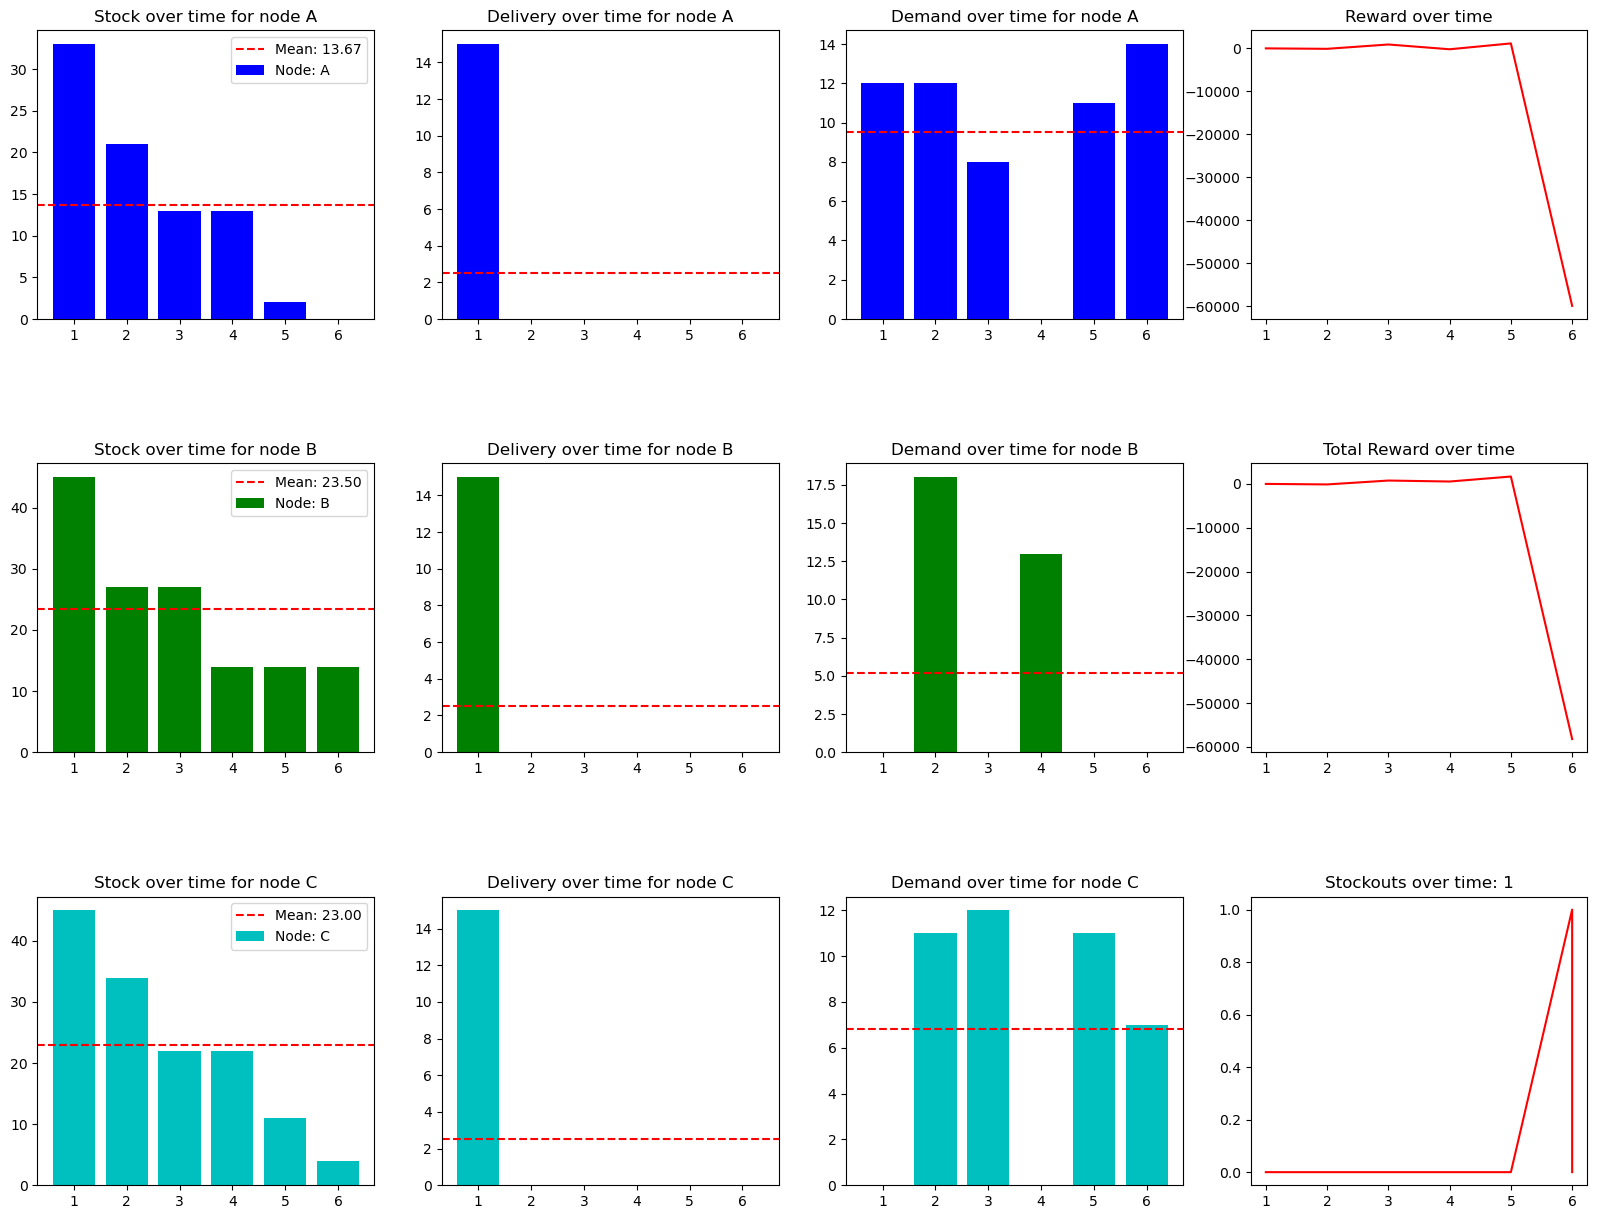

In [23]:
file = './Data/2024-12-20_environment_data_PPO.csv'
df = pd.read_csv(file)

plot_data(df)